In [1]:
%pylab inline
rcParams['figure.figsize'] = [16, 3]
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
pylab.rcParams['figure.figsize'] = (20, 12)

In [3]:
df = pd.read_csv('data/sample1.csv', parse_dates=True, index_col=0)
df['Counter'] = df['Counter'].astype(float)
data = df['Counter']
df.head(10)

,Counter
Date,
2014-08-31 15:15:00,800.0
2014-08-31 15:30:00,685.0
2014-08-31 15:45:00,642.0
2014-08-31 16:00:00,637.0
2014-08-31 16:15:00,648.0
2014-08-31 16:30:00,802.0
2014-08-31 16:45:00,804.0
2014-08-31 17:00:00,814.0
2014-08-31 17:15:00,646.0


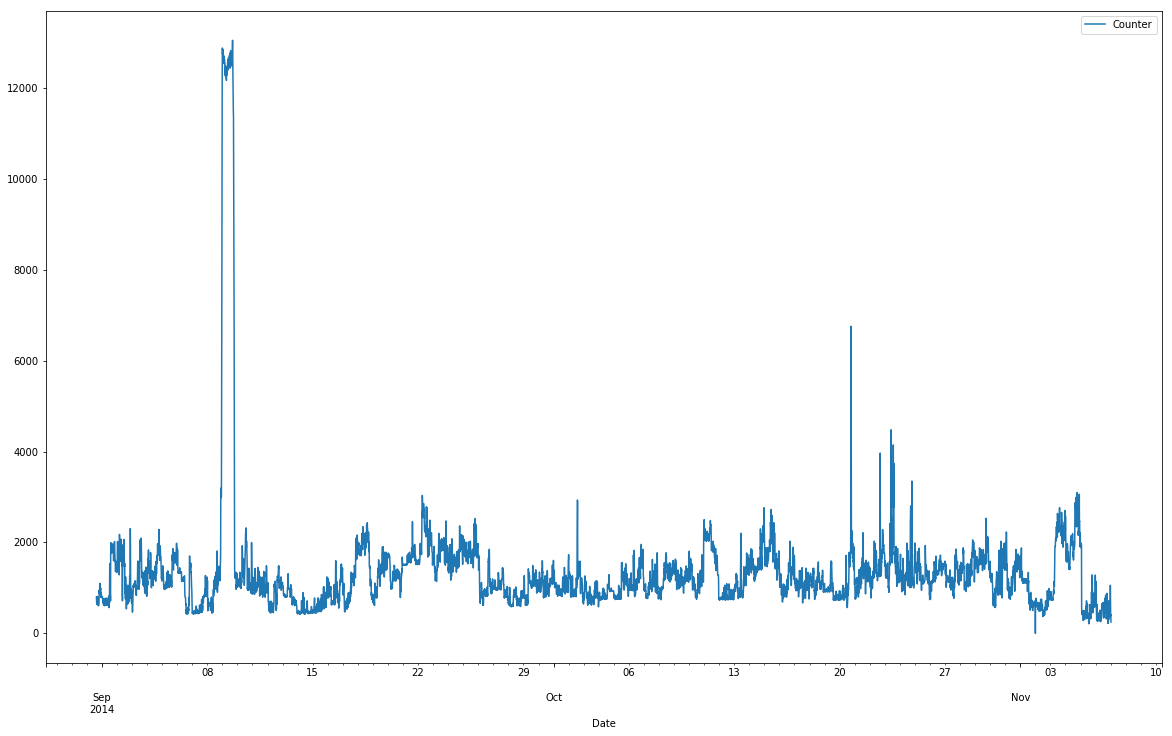

In [4]:
df.plot()

In [5]:
from datetime import timedelta
from datetime import datetime

In [6]:
exception_deviation = 428
exception_window_size = +inf
compression_deviation = exception_deviation / 2
compression_window_size = +inf

In [7]:
exception = {}

exception_window_counter = 0

first_value_encountered = False

last_time = df.index[0]
last_value = data[0]

for index in range(len(data)):
    if index == 0:
        continue
    if math.isnan(data[index]):
        continue
    if not first_value_encountered:
        snapshot_time = df.index[index]
        snapshot_value = data[index]
        
        exception[snapshot_time] = [snapshot_time, snapshot_value]
        first_value_encountered = True
        continue
    
    last_time = df.index[index]
    last_value = data[index]
    
    if abs(snapshot_value - data[index]) > exception_deviation:
        if df.index[index - 1] not in exception:
            exception[df.index[index - 1]] =  [df.index[index - 1], data[index - 1]]
        if df.index[index] not in exception:
            exception[df.index[index]] = [df.index[index], data[index]]
        exception_window_counter = 0
    else:
        exception_window_counter = (exception_window_counter + 1) % exception_window_size
        
        if exception_window_counter == 0:
            if df.index[index] not in exception:
                exception[df.index[index]] = [df.index[index], data[index]]
    
    if exception_window_counter == 0:
        snapshot_time = df.index[index]
        snapshot_value = data[index]

if last_time not in exception:
    exception[last_time] = [last_time, last_value]
    
exception

{Timestamp('2014-08-31 15:30:00'): [Timestamp('2014-08-31 15:30:00'), 685.0],
 Timestamp('2014-09-01 12:00:00'): [Timestamp('2014-09-01 12:00:00'), 667.0],
 Timestamp('2014-09-01 12:15:00'): [Timestamp('2014-09-01 12:15:00'), 1252.0],
 Timestamp('2014-09-01 13:00:00'): [Timestamp('2014-09-01 13:00:00'), 853.0],
 Timestamp('2014-09-01 13:15:00'): [Timestamp('2014-09-01 13:15:00'), 812.0],
 Timestamp('2014-09-01 13:45:00'): [Timestamp('2014-09-01 13:45:00'), 719.0],
 Timestamp('2014-09-01 14:00:00'): [Timestamp('2014-09-01 14:00:00'), 1802.0],
 Timestamp('2014-09-01 21:30:00'): [Timestamp('2014-09-01 21:30:00'), 1428.0],
 Timestamp('2014-09-01 21:45:00'): [Timestamp('2014-09-01 21:45:00'), 1358.0],
 Timestamp('2014-09-02 00:30:00'): [Timestamp('2014-09-02 00:30:00'), 1613.0],
 Timestamp('2014-09-02 00:45:00'): [Timestamp('2014-09-02 00:45:00'), 1993.0],
 Timestamp('2014-09-02 01:45:00'): [Timestamp('2014-09-02 01:45:00'), 1672.0],
 Timestamp('2014-09-02 02:00:00'): [Timestamp('2014-09-02

In [8]:
print("{} {}".format((len(data) - len(exception)), "number of data points discarded as part of exception window"))

5756 number of data points discarded as part of exception window


In [9]:
print("{} {}".format(len(exception), "data points remaining"))

714 data points remaining


In [10]:
exception_df = pd.DataFrame.from_dict(exception, orient='index')
exception_df.columns = ['Date', 'Counter']
exception_df.set_index('Date', inplace=True)

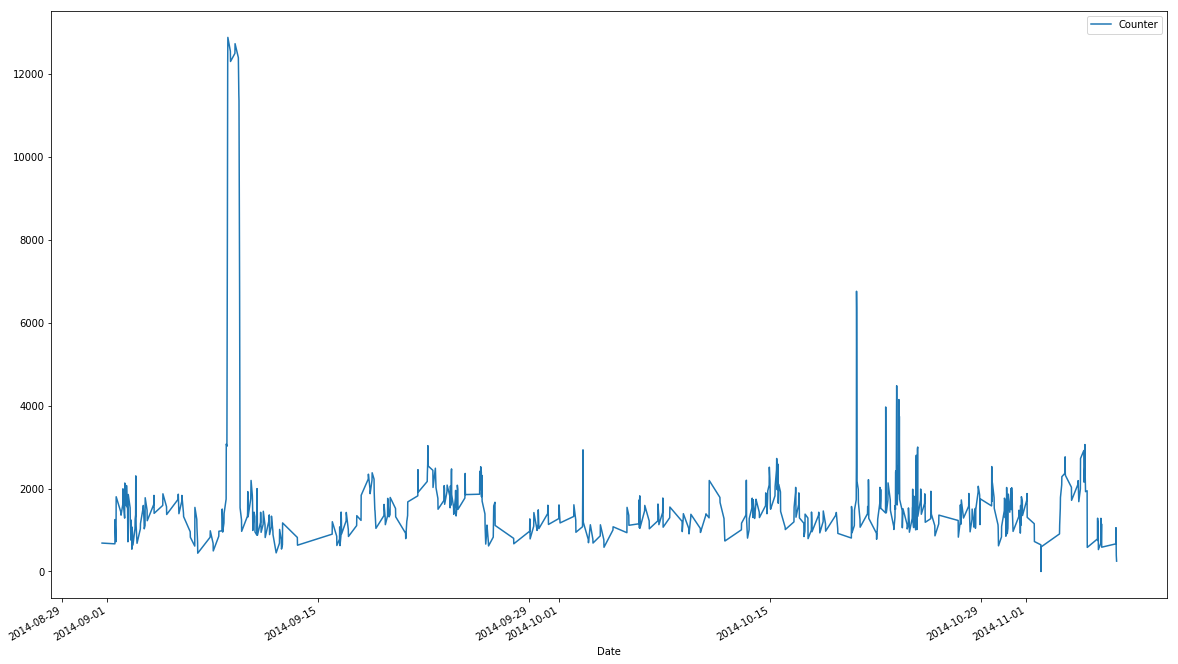

In [11]:
exception_df.plot()

In [12]:
slope_max = +inf
slope_min = -inf

first_value_encountered = False

compression = {}

compression_window_counter = 0

last_time = exception_df.index[0]
last_value = exception_df['Counter'][0]

for index in range(len(exception_df['Counter'])):
    if index == 0:
        continue
    if math.isnan(data[index]):
        continue
    if not first_value_encountered:
        snapshot_time = exception_df.index[index]
        snapshot_value = exception_df['Counter'][index]
        
        compression[snapshot_time] = [snapshot_time, snapshot_value]
        first_value_encountered = True
        continue
    
    last_time = exception_df.index[index]
    last_value = exception_df['Counter'][index]
    
    curr_slope = (exception_df['Counter'][index] - snapshot_value) / ((exception_df.index[index] - snapshot_time).total_seconds() * 1000)
    
    curr_slope_max = (exception_df['Counter'][index] + compression_deviation - snapshot_value) / ((exception_df.index[index] - snapshot_time).total_seconds() * 1000)
    curr_slope_min = (exception_df['Counter'][index] - compression_deviation - snapshot_value) / ((exception_df.index[index] - snapshot_time).total_seconds() * 1000)

    slope_max = min(slope_max, curr_slope_max)
    slope_min = max(slope_min, curr_slope_min)
        
    if curr_slope < slope_min or curr_slope > slope_max:
        compression_window_counter = 0
    else:
        compression_window_counter = (compression_window_counter + 1) % compression_window_size
            
    if compression_window_counter == 0:
        if exception_df.index[index] not in compression:
            compression[exception_df.index[index]] = [exception_df.index[index], exception_df['Counter'][index]]
        
        snapshot_time = exception_df.index[index]
        snapshot_value = exception_df['Counter'][index]

        slope_max = (exception_df['Counter'][index] + compression_deviation - exception_df['Counter'][index - 1]) / ((exception_df.index[index] - exception_df.index[index - 1]).total_seconds() * 1000)
        slope_min = (exception_df['Counter'][index] - compression_deviation - exception_df['Counter'][index - 1]) / ((exception_df.index[index] - exception_df.index[index - 1]).total_seconds() * 1000)
        
compression[last_time] = [last_time, last_value]
compression

{Timestamp('2014-09-01 12:00:00'): [Timestamp('2014-09-01 12:00:00'), 667.0],
 Timestamp('2014-09-01 13:00:00'): [Timestamp('2014-09-01 13:00:00'), 853.0],
 Timestamp('2014-09-01 13:15:00'): [Timestamp('2014-09-01 13:15:00'), 812.0],
 Timestamp('2014-09-01 14:00:00'): [Timestamp('2014-09-01 14:00:00'), 1802.0],
 Timestamp('2014-09-01 21:30:00'): [Timestamp('2014-09-01 21:30:00'), 1428.0],
 Timestamp('2014-09-01 21:45:00'): [Timestamp('2014-09-01 21:45:00'), 1358.0],
 Timestamp('2014-09-02 00:45:00'): [Timestamp('2014-09-02 00:45:00'), 1993.0],
 Timestamp('2014-09-02 01:45:00'): [Timestamp('2014-09-02 01:45:00'), 1672.0],
 Timestamp('2014-09-02 03:45:00'): [Timestamp('2014-09-02 03:45:00'), 2133.0],
 Timestamp('2014-09-02 05:45:00'): [Timestamp('2014-09-02 05:45:00'), 1835.0],
 Timestamp('2014-09-02 06:00:00'): [Timestamp('2014-09-02 06:00:00'), 1583.0],
 Timestamp('2014-09-02 06:15:00'): [Timestamp('2014-09-02 06:15:00'), 1850.0],
 Timestamp('2014-09-02 07:15:00'): [Timestamp('2014-09-

In [13]:
print("{} {}".format((len(exception) - len(compression)), "number of data points discarded as part of compression window"))


167 number of data points discarded as part of compression window


In [14]:
print("{} {}".format(len(compression), "data points remaining"))


547 data points remaining


In [15]:
compression_df = pd.DataFrame.from_dict(compression, orient='index')
compression_df.columns = ['Date', 'Counter']
compression_df.set_index('Date', inplace=True)

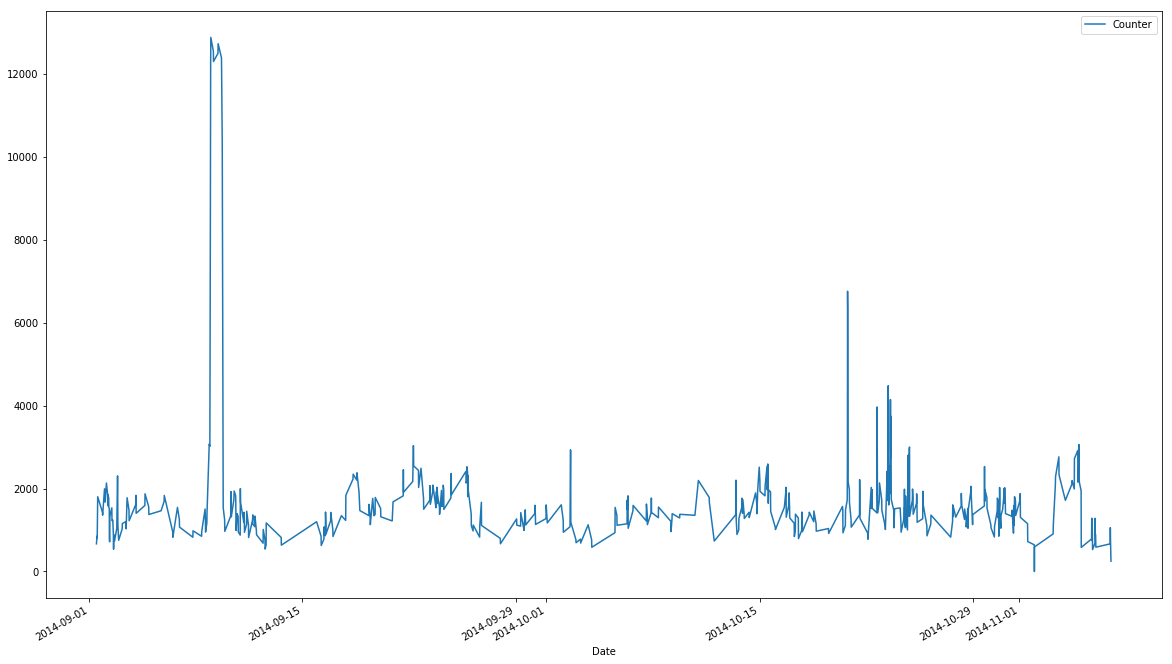

In [16]:
pylab.rcParams['figure.figsize'] = (20, 12)
compression_df.plot()